In [0]:
import torch
from transformers import pipeline
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

2024-08-29 13:21:51.959129: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [0]:
# Load the dataset
dataset = load_dataset('Cyproxius/GutenbergMIA_temporal', split="GutenbergMIA_length128")

/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:45: UserWarning: The cache_dir for this dataset is /root/.cache, which is not a persistent path.Therefore, if/when the cluster restarts, the downloaded dataset will be lost.The persistent storage options for this workspace/cluster config are: [DBFS].Please update either `cache_dir` or the environment variable `HF_DATASETS_CACHE`to be under one of the following root directories: ['/dbfs/']
  warnings.warn(warning_message)


/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:14: UserWarning: During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.
  warnings.warn(


Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating GutenbergMIA_length32 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating GutenbergMIA_length64 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating GutenbergMIA_length128 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating GutenbergMIA_length256 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [0]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [0]:
# # Define the possible labels for each subject
# subject_labels = {
#     'Adventure stories': ['Adventure stories', 'This is a text from a book in the genre adventure stories.', 'This is an excerpt from a 1900s book on adventure stories.', 'Adventure story book'],

#     'Detective and mystery stories': ['Detective and mystery stories', 'This is a text from a book in the genre detective and mystery stories.', 'This is an excerpt from a 1900s book on detective and mystery stories.', 'Detective and mystery story book'],

#     'Historical fiction': ['Historical fiction', 'This is a text from a book in the genre historical fiction.', 'This is an excerpt from a 1900s book on historical fiction.', 'Historical fiction book'],

#     'Love stories': ['Love stories', 'This is a text from a book in the genre love stories.', 'This is an excerpt from a 1900s book on love stories.', 'Love story book'],

#     'Western stories': ['Western stories', 'This is a text from a book in the genre western stories.', 'This is an excerpt from a 1900s book on western stories.', 'Western story book'],

#     'Overall': ['Stories', 'This is a text from a book.', 'This is an excerpt from a 1900s book.', 'Book']
# }

subject_labels = {
    'Adventure stories': ['cooking', 'bungeejumping', 'The Declaration of Independence', 'Supermarket', "Cinematic"],

    'Detective and mystery stories': ['cooking', 'bungeejumping', 'The Declaration of Independence', 'Supermarket', "Cinematic"],

    'Historical fiction': ['cooking', 'bungeejumping', 'The Declaration of Independence', 'Supermarket', "Cinematic"],

    'Love stories': ['cooking', 'bungeejumping', 'The Declaration of Independence', 'Supermarket', "Cinematic"],

    'Western stories': ['cooking', 'bungeejumping', 'The Declaration of Independence', 'Supermarket', "Cinematic"],

    'Overall': ['cooking', 'bungeejumping', 'The Declaration of Independence', 'Supermarket', "Cinematic"]
}

# Dictionary to store results
results = {
    'Adventure stories': {'label_0': [], 'label_1': []},
    'Detective and mystery stories': {'label_0': [], 'label_1': []},
    'Historical fiction': {'label_0': [], 'label_1': []},
    'Love stories': {'label_0': [], 'label_1': []},
    'Western stories': {'label_0': [], 'label_1': []},
    'Overall': {'label_0': [], 'label_1': []}
}

# Function to perform NLI and get scores
def get_nli_score(clas, premise, hypothesis):
    result = clas(premise, hypothesis)
    return result['scores']  # We are interested in the probability of the 'entailment' class

In [0]:
# Iterate through the dataset
for item in tqdm(dataset):
    input_text = item['input']
    label = item['label']
    subject = item['subject']
    possible_labels = subject_labels[subject]

    # Get NLI scores for each possible label
    score = get_nli_score(classifier, input_text, possible_labels)
    overall_score = get_nli_score(classifier, input_text, subject_labels['Overall'])

    # Store the scores
    results[subject][f'label_{label}'].append(score)
    results['Overall'][f'label_{label}'].append(overall_score)

 49%|████▉     | 

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 1000/1000 [1:00:02<00:00,  3.60s/it]


In [0]:
# Calculate mean and standard deviation
statistics = {}
for subject, labels in results.items():
    statistics[subject] = {
        'label_0': {
            'mean': np.mean(labels['label_0'], axis=0),
            'std': np.std(labels['label_0'], axis=0)
        },
        'label_1': {
            'mean': np.mean(labels['label_1'], axis=0),
            'std': np.std(labels['label_1'], axis=0)
        }
  }

In [0]:
# Print the results
for subject, stats in statistics.items():
    print(f"Subject: {subject}")
    for label, stat in stats.items():
        print(f"  {label}: mean={stat['mean']}, std={stat['std']}")

Subject: Adventure stories
  label_0: mean=[0.41512003 0.22605507 0.16305485 0.10960915 0.0861609 ], std=[0.08650803 0.04137144 0.03369696 0.02571691 0.02503623]
  label_1: mean=[0.40543729 0.2301034  0.16579197 0.11332973 0.08533761], std=[0.06839823 0.03566292 0.02904547 0.02695036 0.02270747]
Subject: Detective and mystery stories
  label_0: mean=[0.40222631 0.23181158 0.16813752 0.11168565 0.08613894], std=[0.10100662 0.04407486 0.04051786 0.03052452 0.02575543]
  label_1: mean=[0.41003125 0.23191744 0.16299257 0.10973582 0.08532292], std=[0.06379875 0.0398707  0.02792299 0.02593752 0.02279882]
Subject: Historical fiction
  label_0: mean=[0.39846967 0.23043968 0.16916044 0.11312607 0.08880413], std=[0.0713099  0.04275621 0.03195742 0.0218686  0.02089167]
  label_1: mean=[0.39337722 0.23533844 0.16846492 0.11466039 0.08815902], std=[0.06496478 0.03963874 0.03048096 0.02198178 0.01889052]
Subject: Love stories
  label_0: mean=[0.40089295 0.22267251 0.16917347 0.11600378 0.09125728], 

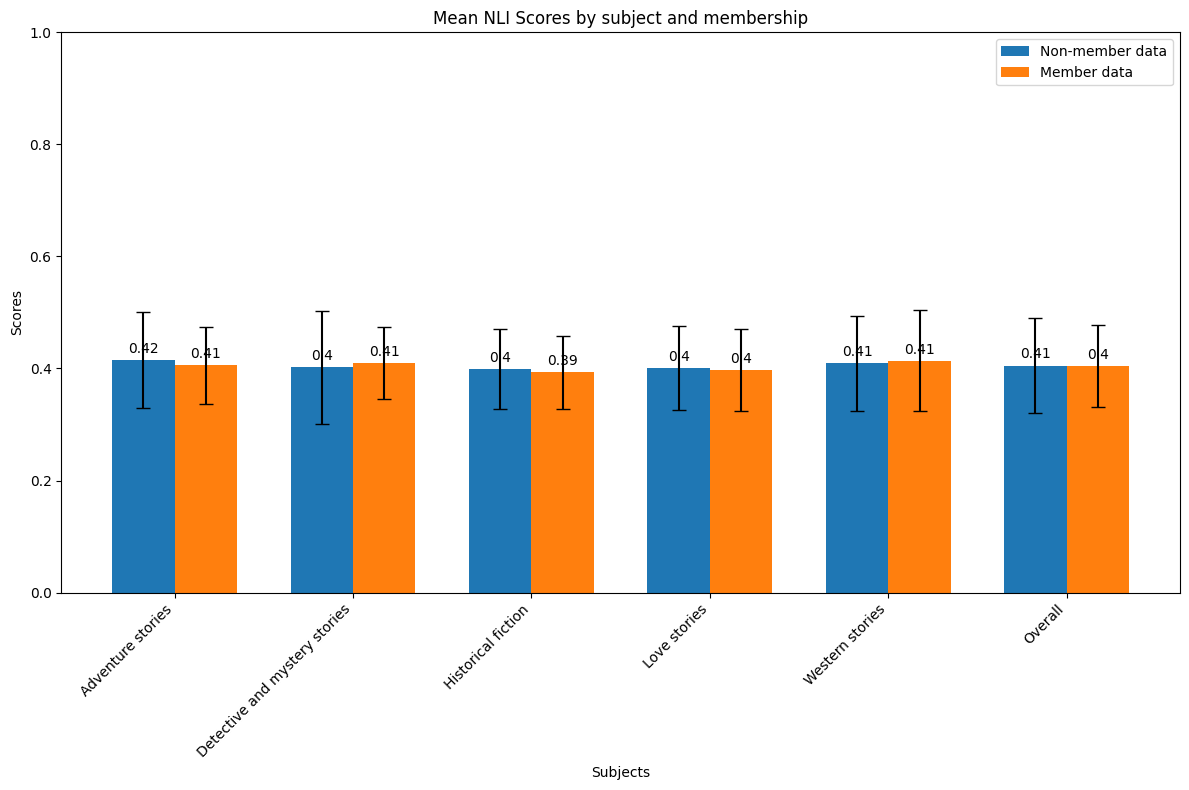

In [0]:
def plot_statistics(statistics):
    subjects = list(statistics.keys())
    labels = ['label_0', 'label_1']
    
    means = {label: [] for label in labels}
    stds = {label: [] for label in labels}
    
    for subject in subjects:
        for label in labels:
            means[label].append(statistics[subject][label]['mean'][0])
            stds[label].append(statistics[subject][label]['std'][0])
    
    x = np.arange(len(subjects))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width/2, means['label_0'], width, yerr=stds['label_0'], label='Non-member data', capsize=5)
    rects2 = ax.bar(x + width/2, means['label_1'], width, yerr=stds['label_1'], label='Member data', capsize=5)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Subjects')
    ax.set_ylabel('Scores')
    ax.set_title('Mean NLI Scores by subject and membership')
    ax.set_ylim([0,1])
    ax.set_xticks(x)
    ax.set_xticklabels(subjects, rotation=45, ha='right')
    ax.legend()
    
    # Attach a text label above each bar in rects, displaying its height.
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    fig.tight_layout()
    
    plt.show()

# Assuming `statistics` dictionary from the previous step is available
plot_statistics(statistics)

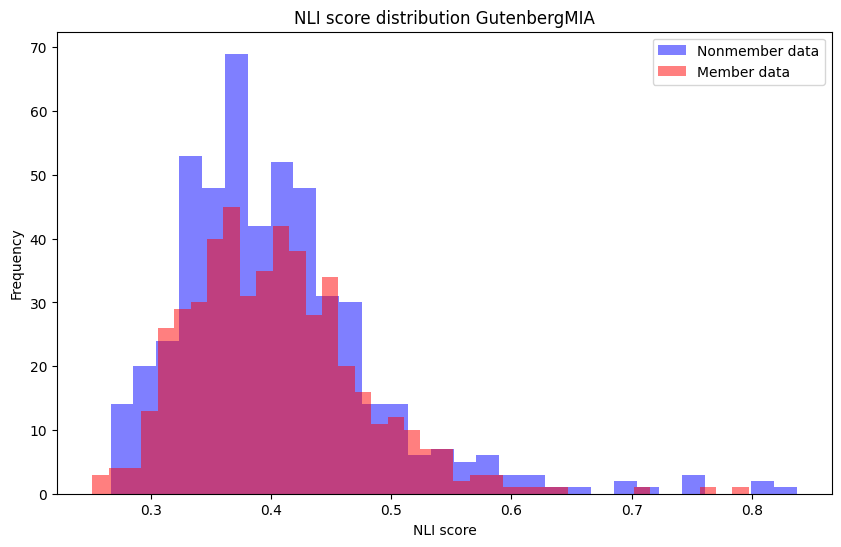

In [0]:
def plot_overlap_histogram(list1, list2, bins=30, alpha=0.5):
    """
    Plots a histogram showing the overlap between two lists of values.
    
    Parameters:
    - list1: First list of values ranging from 0 to 1
    - list2: Second list of values ranging from 0 to 1
    - bins: Number of bins in the histogram
    - alpha: Transparency level of the histograms
    """
    plt.figure(figsize=(10, 6))
    
    # Plot histograms for both lists
    plt.hist(list1, bins=30, alpha=alpha, label='Nonmember data', color='blue')
    plt.hist(list2, bins=40, alpha=alpha, label='Member data', color='red')
    
    # Add labels and title
    plt.xlabel('NLI score')
    plt.ylabel('Frequency')
    plt.title('NLI score distribution GutenbergMIA')
    plt.legend(loc='upper right')
    
    # Show the plot
    plt.show()
# print(results['Overall'])
nonmember_dist = [i[0] for i in results['Overall']['label_0']]
member_dist = [i[0] for i in results['Overall']['label_1']]
plot_overlap_histogram(nonmember_dist, member_dist)